# Lab assignment: tuning decision trees from imbalanced data

<img src="img/surgery.jpg" style="width:640px;height:406px;">

In this assignment we will apply a decision tree to solve an imbalanced problem, where positive patterns are scarce and the cost of making a mistake in this class is high. We will tune the tree construction method to take these facts into account.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="img/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Preliminaries

First of all, let's fix a random seed so all results are reproducible in different runs of the notebook.

In [2]:
import numpy as np
import pandas as pd
np.random.seed(12345)

The following code will embed any plots into the notebook instead of generating a new window:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

We will make use of the [Thoracic Surgery Dataset](https://www.kaggle.com/sid321axn/thoraric-surgery), collected by the Wroclaw Thoracic Surgery Centre and readily available at Kaggle. The dataset contains information of 470 patients who underwent major lung resections for primary lung cancer in the years 2007-2011. Given a series of preprocessed prescriptor variables, the goal is to predict whether the patient will die within the next year after the surgery, and to find explanations on the major factors influencing this death. This could be helpful to identify patients at risk in future surgeries.

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    
The data is contained in the file <b>ThoraricSurgery.csv</b>. Process the data to perform the following tasks:
- Load all the data into a pandas DataFrame.
- Create dummies for all categorical and binary features.
- Group all explanatory features in a new DataFrame or array <b>X</b>
- Extract the target as new DataFrame or array <b>Y</b>
- Split the data into a training and a testing subset. Use about 1/3 of the data as test data. Use a stratified split.
</font>

***

In [32]:
####### INSERT YOUR CODE HERE

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("ThoraricSurgery.csv", sep=",").set_index("id")
numericaldata = pd.get_dummies(
    data, 
    columns = ["DGN", "PRE6", "PRE7", "PRE8", "PRE9", "PRE10", "PRE11", "PRE14", "PRE17", "PRE19", "PRE25", "PRE30", "PRE32" ]
)

X = numericaldata.drop(["Risk1Yr"], axis=1)
# Y = [1 if d == "T" else 0 for d in data["Risk1Yr"]]
Y = data["Risk1Yr"].map({"T": 1, 'F': 0})

data.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
id,,,,,,,,,,,,,,,,,
1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [28]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, stratify=Y)

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
How many samples are available for the positive class (Risk)? How many for the negative class (No risk)?
</font>

***

In [30]:
####### INSERT YOUR CODE HERE
Y.value_counts()

0    400
1     70
Name: Risk1Yr, dtype: int64

## Objective function

This problem is imbalanced, not only in terms of class samples, but also in terms of costs: classifying a safe patient as a risky one might result in unneeded medical treatments, but classifying a patient at risk as a safe one might result in dead or severe health consequences. Therefore, the cost for False Negatives is much higher than the cost for False Positives. How much higher? Let's suppose we agree that a False Negative is 10 times worse than a False Positive.

In [33]:
FALSE_NEGATIVE_PENALTY = 10

With this, we can define a class-weighted accuracy metric as follows

In [34]:
from sklearn.metrics import confusion_matrix

def weighted_accuracy(y_values, y_preds, fn_penalty):
    conf = confusion_matrix(y_values, y_preds)
    loss = conf[0][1] + conf[1][0] * fn_penalty
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * fn_penalty
    return (maxloss - loss) / maxloss * 100

We can test it works as expected with the following toy examples. First, an array of perfect predictions except for a false positive

In [35]:
y_values = [0, 0, 1, 1]
y_preds =  [0, 1, 1, 1]
print(f"Weighted accuracy = {weighted_accuracy(y_values, y_preds, FALSE_NEGATIVE_PENALTY):.4}%")

Weighted accuracy = 95.45%


Now a similar example with no false positives but one false negative

In [12]:
y_values = [0, 0, 1, 1]
y_preds =  [0, 0, 0, 1]
print(f"Weighted accuracy = {weighted_accuracy(y_values, y_preds, FALSE_NEGATIVE_PENALTY):.4}%")

Weighted accuracy = 54.55%


As we expected, this metric gives much more weight to mistakes made over patients at risk. We will need to take this into account when creating our model.

## Naive model

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Build a decision tree model over the training the data, then measure its weighted accuracy over the test data. You can make use of any pre-pruning, post-pruning or hyperparameters search method, but don't try to correct the class imbalance in any way. What is the best weighted accuracy you can obtain?
    
Create also a visualization of your best tree. Does it make any sense?
</font>

***

1.0.2
Weighted accuracy = 36.6%


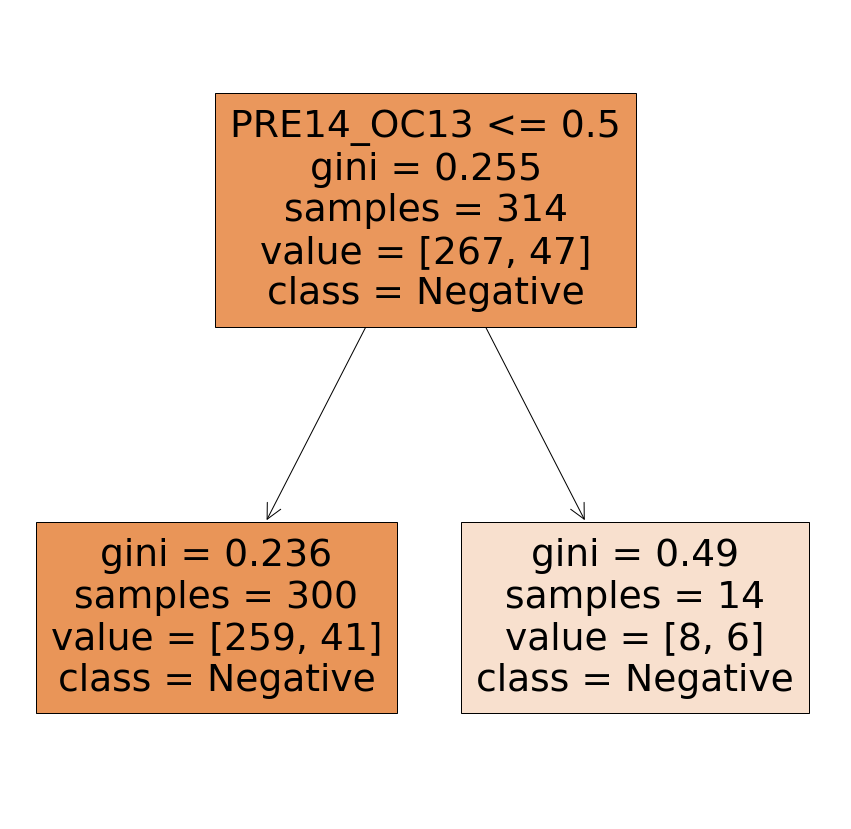

In [42]:
####### INSERT YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

import sklearn as sk
print(sk.__version__)
param_grid = {
    "max_depth": [1, 2, 3, 4],
    "min_samples_split": [ 2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": [1e-3, 1e-2, 1e-1]
}
besttree = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = param_grid,
    n_jobs=8
)
besttree.fit(Xtrain, Ytrain)

preds = besttree.predict(Xtest)
print(f"Weighted accuracy = {weighted_accuracy(Ytest, preds, FALSE_NEGATIVE_PENALTY):.3}%")
plt.figure(figsize=(15,15))
plot_tree(besttree.best_estimator_, feature_names=Xtrain.columns, class_names=["Negative", "Positive"], filled=True)
plt.show()


## Cost-sensitive model

A decision tree can take into account the misclassification costs of each class when deciding the splits to make. This can be done by weighting each pattern by the cost of its class in the computation of impurities. In scikit-learn this is easily implemented through the **class_weight** parameter. For instance, if the class labels were encoded as $0$-$1$, to create a decision tree that gives double the weight to positive class patterns we would need to write

In [ ]:
DecisionTreeClassifier(class_weight={0: 1, 1: 2})

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Build another decision tree model, but this time provide class weights according to the false positive / false negative costs defined previously. What is the best weighted accuracy you can obtain now? Does the visualization of the tree produce more sensible rules?
</font>

***

In [ ]:
####### INSERT YOUR CODE HERE